This used latent space of 1024 and hidden of only 512. But it seems to really struggle because of the smaller hidden space.
    

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import torch
from torch.nn import functional as F
from torch.autograd import Variable
from torch import nn, optim
import torch.utils.data

# load as dask array
import dask.array as da
import dask
import h5py

import os
import glob
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from world_models_sonic.models.vae import VAE5, loss_function_vae
from world_models_sonic.helpers.summarize import TorchSummarizeDf
from world_models_sonic.helpers.dataset import load_cache_data
from world_models_sonic.models.rnn import MDNRNN2
from world_models_sonic import config

# Init

In [4]:
cuda= torch.cuda.is_available()
env_name='sonic256'
num_epochs=200
batch_size = 3

# RNN
action_dim = 12
seq_len = 6
image_size=256
chunksize=seq_len*20

# VAE loss function
gamma = 0.25
C = 0

# loss function weights
lambda_vae = 1/12000
lambda_finv = 1/20

data_cache_file = '/data/tmp/sonic_rnn_256_v6.hdf5'

# Load Data

In [5]:
loader_train, loader_test = load_cache_data(
    basedir=config.base_vae_data_dir, 
    env_name='sonic256', 
    data_cache_file=data_cache_file, 
#     image_size=image_size, 
    chunksize=chunksize, 
    action_dim=action_dim,
    batch_size=batch_size,
    seq_len=seq_len
)
loader_train, loader_test

Loaded from cache /data/tmp/sonic_rnn_256_v6.hdf5


(<torch.utils.data.dataloader.DataLoader at 0x7f89c4bc95c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f89c4bc9978>)

# Load VAE

In [6]:
# Load VAE
vae = VAE5(image_size=image_size, z_dim=128, conv_dim=64, code_dim=8, k_dim=512)
if cuda:
    vae.cuda()
    
# # Resume
NAME='RNN_v3b_256im_512z_1512_v2'

checkpoint_file = f'./outputs/models/RNN_v3b_256im_512z-joint-training_state_dict.pkl'
if os.path.isfile(checkpoint_file):
    state_dict = torch.load(checkpoint_file)
    vae.load_state_dict(state_dict)
    print(f'loaded checkpoint_file {checkpoint_file}')
    
save_file = f'./outputs/models/{NAME}-vae_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    vae.load_state_dict(state_dict)
    print(f'loaded save_file {save_file}')

loaded checkpoint_file ./outputs/models/RNN_v3b_256im_512z-joint-training_state_dict.pkl


# Load RNN

In [7]:
# Load MDRNN
z_dim, action_dim, hidden_size, n_mixture, temp = 512, 12, 512, 3, 0.0


mdnrnn = MDNRNN2(z_dim, action_dim, hidden_size, n_mixture, temp)

if cuda:
    mdnrnn = mdnrnn.cuda()

In [8]:
# # Resume?
save_file = f'./outputs/models/{NAME}-mdnrnn_state_dict.pkl'
if os.path.isfile(save_file):
    state_dict = torch.load(save_file)
    mdnrnn.load_state_dict(state_dict)
    print(f'loaded {save_file}')

# Load inverse model

In [9]:
class FInv(torch.nn.modules.Module):
    def __init__(self, z_dim, action_dim, hidden_size):
        """
        Inverse model from https://arxiv.org/abs/1804.10689.
        
        Takes in z and z' and outputs predicted action
        """
        super().__init__()
        self.ln1 = nn.Linear(z_dim*2, hidden_size)
        self.ln2 = nn.Linear(hidden_size, hidden_size)
        self.ln3 = nn.Linear(hidden_size,  action_dim)
        
    def forward(self, z_now, z_next):
        x = torch.cat((z_now, z_next), dim=-1)
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln2(x))
        x = F.sigmoid(self.ln3(x))
        return x

In [10]:
finv = FInv(z_dim, action_dim, hidden_size=256).cuda()

# Summarize models

In [11]:
img = np.random.randn(image_size, image_size, 3)
action = Variable(torch.from_numpy(np.random.randint(0,12,(12)))).float().cuda()[np.newaxis]
gpu_img = Variable(torch.from_numpy(img[np.newaxis].transpose(0, 3, 1, 2))).float().cuda()
if cuda:
    gpu_img = gpu_img.cuda()
with TorchSummarizeDf(vae) as tdf:
    x, mu_vae, logvar_vae = vae.forward(gpu_img)
    z = vae.sample(mu_vae, logvar_vae)
    df_vae = tdf.make_df()
#     loss_recon, loss_KLD = loss_function_vae(Y, x, mu_vae, sigma_vae)
#     loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
#     loss_vae = loss_vae.mean() # mean along the batches
with TorchSummarizeDf(mdnrnn) as tdf: 
    pi, mu, sigma, hidden_state = mdnrnn.forward(z.unsqueeze(1).repeat((1,2,1)), action.unsqueeze(1).repeat((1,2,1)))
    z_next = mdnrnn.sample(pi, mu, sigma)
#     loss_mdn = mdnrnn.rnn_loss(z, pi, mu, sigma).mean()
    df_mdnrnn = tdf.make_df()

#     loss = loss_mdn + gamma_vae * loss_vae
with TorchSummarizeDf(finv) as tdf:
    action_pred = finv(z.repeat((1,2,1)), z_next)
        
    df_finv = tdf.make_df()
    
del img, action, gpu_img, x, mu, z


Total parameters 21877123
Total trainable parameters 21877123
Total parameters 15502848
Total trainable parameters 15502848
Total parameters 331276
Total trainable parameters 331276


In [12]:
df_vae[df_vae.level<2]

,name,class_name,input_shape,output_shape,nb_params,level
4,encoder.0,ConvBlock4,"[(-1, 3, 256, 256)]","[(-1, 64, 256, 256)]",1920,1
8,encoder.1,ConvBlock4,"[(-1, 64, 256, 256)]","[(-1, 128, 128, 128)]",131456,1
12,encoder.2,ConvBlock4,"[(-1, 128, 128, 128)]","[(-1, 192, 64, 64)]",393792,1
16,encoder.3,ConvBlock4,"[(-1, 192, 64, 64)]","[(-1, 256, 32, 32)]",787200,1
20,encoder.4,ConvBlock4,"[(-1, 256, 32, 32)]","[(-1, 320, 16, 16)]",1311680,1
24,encoder.5,ConvBlock4,"[(-1, 320, 16, 16)]","[(-1, 384, 8, 8)]",1967232,1
25,encoder.6,Conv2d,"[(-1, 384, 8, 8)]","[(-1, 128, 8, 8)]",49280,1
26,mu,Linear,"[(-1, 8192)]","[(-1, 512)]",4194816,0
27,logvar,Linear,"[(-1, 8192)]","[(-1, 512)]",4194816,0
28,z,Linear,"[(-1, 512)]","[(-1, 8192)]",4202496,0


In [13]:
df_finv

,name,class_name,input_shape,output_shape,nb_params,level
1,ln1,Linear,"[(-1, 2, 1024)]","[(-1, 2, 256)]",262400,0
2,ln2,Linear,"[(-1, 2, 256)]","[(-1, 2, 256)]",65792,0
3,ln3,Linear,"[(-1, 2, 256)]","[(-1, 2, 12)]",3084,0


In [14]:
df_mdnrnn

,name,class_name,input_shape,output_shape,nb_params,level
1,rnn,LSTM,"[[(-1, 2, 524)], [[(-1, 1, 512)], [(-1, 1, 512...","[[(-1, 2, 512)], [[(-1, 1, 512)], [(-1, 1, 512...",2125824,0
2,ln1,Linear,"[(-1, 512), (-1, 512)]","[(-1, 512), (-1, 512)]",262656,0
3,ln2,Linear,"[(-1, 512), (-1, 512)]","[(-1, 2560), (-1, 2560)]",1313280,0
4,mdn,Linear,"[(-1, 2560), (-1, 2560)]","[(-1, 4608), (-1, 4608)]",11801088,0


# Init

In [15]:
class Model(torch.nn.modules.Module):
    def __init__(self, vae, mdnrnn, finv):
        super().__init__()
        self.vae = vae
        self.mdnrnn = mdnrnn
        self.finv = finv
        
model = Model(vae, mdnrnn, finv)

In [16]:

torch.save(finv.state_dict(), f'./outputs/models/{NAME}-finv_state_dict.pkl')

In [17]:

import torch.optim.lr_scheduler
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

# optimizer_vae = optim.Adam(vae.parameters(), lr=3e-5)
# scheduler_vae = optim.lr_scheduler.ReduceLROnPlateau(optimizer_vae, mode='min', patience=3, verbose=True)

# Train helpers

In [18]:
# Plot reconstructions
def plot_results(loader, n=2, epoch=0, figsize=(9,6)):
    vae.eval()
    mdnrnn.eval()
    
    observations, actions, rewars, dones = next(iter(loader))
    
    X = Variable(observations.transpose(1,3))
    _, channels, height, width = X.size()
    if cuda:
        X=X.cuda()
    Y, mu_vae, logvar = vae.forward(X)
    loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
    loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
    
    # TODO do we want to sample in test or training mode?
    z_v = vae.sample(mu_vae, logvar)
    
    z_v = z_v.view(batch_size, seq_len, -1)
    Y = Y.view((batch_size, seq_len, channels, height, width))
    X = X.view((batch_size, seq_len, channels, height, width))
    loss_vae = loss_vae.view(batch_size, seq_len, -1)
    actions = actions.view(batch_size, seq_len, -1)
    
    # Forward
    actions_v = Variable(actions).float()
    

    if cuda:
        z_v=z_v.cuda()
        actions_v=actions_v.cuda()
    pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

    loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma)
    
    mu = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
    X_pred = vae.decode(mu)
    X_pred = X_pred.view((batch_size, seq_len, channels, height, width))
    
    # TODO finv    
    
    for i in np.linspace(0,seq_len-2,n):
        batch = np.random.randint(0,batch_size)
        i=int(i)
        y=Y[batch][i].cpu().data.transpose(0,2).numpy()
        x_orig = X[batch][i].transpose(0,2).data.cpu().numpy()
        x_next = X[batch][i+1].transpose(0,2).data.cpu().numpy()
        x_pred = X_pred[batch][i].transpose(0,2).data.cpu().numpy()
        loss_vae_i = loss_vae[batch][i].cpu().data.item()
        loss_i = loss[batch].cpu().data.item()
        
        plt.figure(figsize=figsize)
        
        plt.subplot(2, 3, 1)
        plt.axis("off")
        plt.title('original')
        plt.imshow(x_orig)

        plt.subplot(2, 3, 4)
        plt.axis("off")
        plt.imshow(y)
        plt.title('reconstructed')
           
        plt.subplot(2, 3, 2)
        plt.axis("off")
        plt.imshow(x_next)
        plt.title('true next')
        
        plt.subplot(2, 3, 5)
        plt.axis("off")
        plt.imshow(x_pred)
        plt.title('pred next')
        
        plt.subplot(2, 3, 3)
        plt.axis("off")
        plt.imshow(np.abs(x_orig-x_next))
        plt.title('actual changes')
        
        plt.subplot(2, 3, 6)
        plt.axis("off")
        plt.imshow(np.abs(y[i]-x_pred))
        plt.title('predicted changes')

        plt.suptitle('epoch {}, seq index {}, batch={}. vae_loss {:2.4f}, loss {:2.4f}'.format(
            epoch, 
            i,
            batch,
            loss_vae_i, 
            loss_i
        ))
#         plt.subplots_adjust(wspace=-.4, hspace=.1)#, bottom=0.1, right=0.8, top=0.9)
        plt.show()
        


TODO

- [ ] make a module containing all 3 including inverse model from https://arxiv.org/pdf/1804.10689.pdf
    - that way they can use the same optimizer
- [ ] do dual training

In [19]:
import collections

def train(loader, vae, mdnrnn, optimizer, max_batches=None, test=False, cuda=True, joint_training=False):
    vae.eval()
    if test:
        mdnrnn.eval()
    else:
        mdnrnn.train()
    info = collections.defaultdict(list)
    hidden_state = None
    if max_batches is None:
        max_batches = len(loader)
    else:
        max_batches = min(max_batches, len(loader))
    iterator = iter(loader)

    with tqdm(total=max_batches*loader.batch_size, mininterval=0.5, desc='test' if test else 'training') as prog:
        for i in range(max_batches):
            # the loader batch_size is seq_len*batch_size
            # we put it through the VAE as (seq_len*batch_size,...)
            # then reshape to (batch_size,seq_len,...) for the mdnrnn
            observations, actions, rewards, dones = next(iterator)
            X = Variable(observations.transpose(1,3))
            if cuda:
                X=X.cuda()
                
            # VAE forward
            Y, mu_vae, logvar = vae.forward(X)
            
            loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
            loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)
            loss_vae = loss_vae.mean() # mean along the batches

            # MDNRNN Forward
            # Detaching z_v block the gradient which seems to stabalize the training
            z_v = vae.sample(mu_vae, logvar)
            z_v = z_v.view(batch_size, seq_len, -1).detach()
            actions_v = Variable(actions).float()
            actions_v = actions_v.view(batch_size, seq_len, -1)
            if cuda:
                z_v=z_v.cuda()
                actions_v=actions_v.cuda()
            pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

            # We are evaluating how the output distribution for the next step
            # matches the real next step. So we have to discard the last step in the 
            # sequence which has no next step.
            z_true_next = z_v[:,1:]
            loss_mdn = mdnrnn.rnn_loss(z_true_next, pi[:,:-1], mu[:,:-1], sigma[:,:-1]).mean()
            
            # Finv forward
            z_next_pred = mdnrnn.sample(pi, mu, sigma)
            action_pred = finv(z_v[:,1:], z_next_pred[:,:-1])
            loss_inv = ((action_pred-actions_v[:,1:])**2).sum(-1)
            loss_inv = loss_inv.mean()
            
            loss = loss_mdn# + lambda_finv * loss_inv #+ lambda_vae * loss_vae

            if not test:
                optimizer.step()
                optimizer.zero_grad()

            # Record
            info['loss_inv'].append(loss_inv.cpu().data.numpy())
            info['loss_mdn'].append(loss_mdn.cpu().data.numpy())
            info['loss_vae'].append(loss_vae.cpu().data.numpy())
            info['loss_recon'].append(loss_recon.mean().cpu().data.item())
            info['loss_KLD'].append(loss_KLD.mean().cpu().data.item())
            
            prog.update(loader.batch_size)
            prog.desc='loss_rnn={loss_mdn:2.4f}, loss_inv= {lambda_finv}* {loss_inv:2.4f}, loss_vae={lambda_vae:2.4f} * ({loss_recon:2.2f} + {gamma}*|{loss_KLD:2.2f} - {C}|)'.format(
                loss_mdn=np.mean(info['loss_mdn']), 
                loss_recon=np.mean(info['loss_recon']),
                gamma=gamma,
                lambda_finv=lambda_finv,
                lambda_vae=lambda_vae,
                C=C,
                loss_KLD=np.mean(info['loss_KLD']),
                loss_inv=np.mean(info['loss_inv'])
            )
            if i%400==0:
                print('[{}/{}]'.format(i, max_batches), prog.desc)

        print(prog.desc)
        prog.close()

    return info

# Train

In [20]:
max_batches=60000//loader_train.batch_size
max_batches
torch.cuda.empty_cache()

In [21]:
# Load previous history
import pandas as pd
if os.path.isfile(f'./outputs/models/{NAME}.csv'):
    histories = pd.read_csv(f'./outputs/models/{NAME}.csv').to_dict(orient='records')
else:
    histories = []

[0/3333] loss_rnn=1.0519, loss_inv= 0.05* 2.9454, loss_vae=0.0001 * (791.50 + 0.25*|68.00 - 0|)


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


[400/3333] loss_rnn=1.0561, loss_inv= 0.05* 2.9758, loss_vae=0.0001 * (2185.58 + 0.25*|70.17 - 0|)
[800/3333] loss_rnn=1.0550, loss_inv= 0.05* 2.9748, loss_vae=0.0001 * (2140.45 + 0.25*|69.58 - 0|)
[1200/3333] loss_rnn=1.0546, loss_inv= 0.05* 2.9754, loss_vae=0.0001 * (2088.09 + 0.25*|69.41 - 0|)
[1600/3333] loss_rnn=1.0559, loss_inv= 0.05* 2.9755, loss_vae=0.0001 * (2143.57 + 0.25*|70.04 - 0|)
[2000/3333] loss_rnn=1.0557, loss_inv= 0.05* 2.9751, loss_vae=0.0001 * (2158.36 + 0.25*|69.95 - 0|)
[2400/3333] loss_rnn=1.0567, loss_inv= 0.05* 2.9752, loss_vae=0.0001 * (2171.02 + 0.25*|70.48 - 0|)
[2800/3333] loss_rnn=1.0569, loss_inv= 0.05* 2.9750, loss_vae=0.0001 * (2176.88 + 0.25*|70.57 - 0|)
[3200/3333] loss_rnn=1.0576, loss_inv= 0.05* 2.9751, loss_vae=0.0001 * (2205.48 + 0.25*|70.91 - 0|)
loss_rnn=1.0575, loss_inv= 0.05* 2.9751, loss_vae=0.0001 * (2209.85 + 0.25*|70.85 - 0|)



[0/555] loss_rnn=1.0460, loss_inv= 0.05* 2.9745, loss_vae=0.0001 * (1925.94 + 0.25*|64.78 - 0|)
[400/555] loss_rnn=1.0557, loss_inv= 0.05* 2.9749, loss_vae=0.0001 * (2095.42 + 0.25*|69.92 - 0|)
loss_rnn=1.0567, loss_inv= 0.05* 2.9746, loss_vae=0.0001 * (2081.20 + 0.25*|70.45 - 0|)

Epoch 0, loss=1.0575, loss_val=1.0567, loss_vae=2227.5581, loss_vae_val=2098.8140,  loss_finv=nan, loss_finv_vae=nan, ,


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


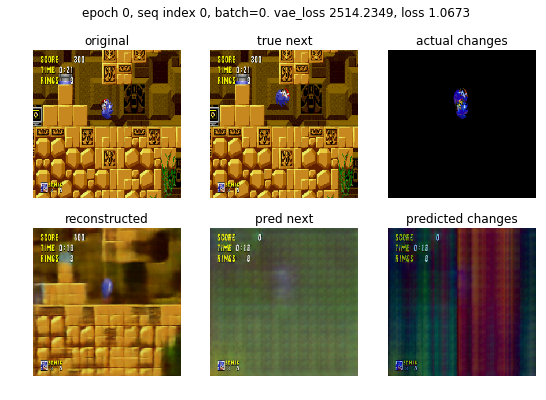

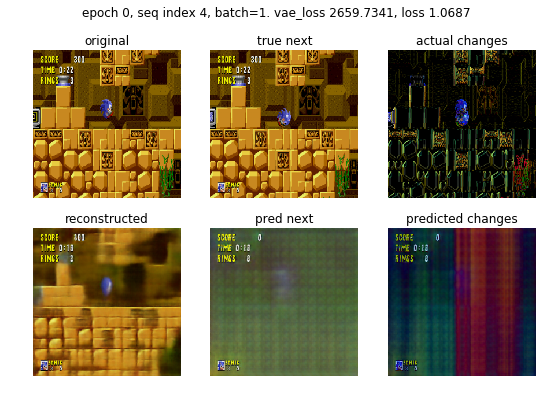

[0/3333] loss_rnn=1.0580, loss_inv= 0.05* 2.9808, loss_vae=0.0001 * (1673.30 + 0.25*|71.36 - 0|)


In [ ]:
for epoch in range(num_epochs):
    # Run
    info = train(loader_train, vae, mdnrnn, optimizer, max_batches=max_batches, test=False, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    info_val = train(loader_test, vae, mdnrnn, optimizer, max_batches=max_batches//6, test=True, cuda=True, joint_training=True)
    torch.cuda.empty_cache()
    
    # Adjust
    scheduler.step(np.mean(info_val['loss_mdn']))
    
    # View
    print('Epoch {}, loss={:2.4f}, loss_val={:2.4f}, loss_vae={:2.4f}, loss_vae_val={:2.4f},  loss_finv={:2.4f}, loss_finv_vae={:2.4f}, ,'.format(
        epoch, 
        np.mean(info['loss_mdn']), 
        np.mean(info_val['loss_mdn']),
        np.mean(info['loss_vae']), 
        np.mean(info_val['loss_vae']),
        np.mean(info['loss_finv']),
        np.mean(info_val['loss_finv'])
    ))
    plot_results(loader_test, n=2, epoch=epoch)
    
    # Record
    history = {k+'_val':np.mean(v) for k,v in info_val.items()}
    history.update({k:np.mean(v) for k,v in info.items()})
    histories.append(history)
    
    torch.save(mdnrnn.state_dict(), f'./outputs/models/{NAME}-mdnrnn_{epoch}_state_dict.pkl')
    torch.save(vae.state_dict(), f'./outputs/models/{NAME}-vae_{epoch}_state_dict.pkl')
    torch.save(finv.state_dict(), f'./outputs/models/{NAME}-finv_{epoch}_state_dict.pkl')
    
    # Tidy
    torch.cuda.empty_cache()

In [ ]:
import pandas as pd
df_history = pd.DataFrame(histories)
df_history.plot()

In [ ]:
df_history[['loss_mdn','loss_mdn_val']].plot()

In [ ]:
df_history[['loss_vae','loss_vae_val']].plot()

In [ ]:
df_history[['loss_inv','loss_inv_val']].plot()

## Save

In [ ]:
torch.save(mdnrnn.state_dict(), f'./outputs/models/{NAME}-mdnrnn_state_dict.pkl')
torch.save(vae.state_dict(), f'./outputs/models/{NAME}-vae_state_dict.pkl')
torch.save(finv.state_dict(), f'./outputs/models/{NAME}-finv_state_dict.pkl')
df_history.to_csv(f'./outputs/models/{NAME}.csv', index=False)

# torch.save(mdnrnn, f'./outputs/models/{NAME}-mdnrnn.pkl')
# torch.save(vae, f'./outputs/models/{NAME}-vae')
# torch.save(finv.state_dict(), f'./outputs/models/{NAME}-finv.pkl')

## View

In [ ]:
plot_results(loader_test, n=4, epoch=0)

In [ ]:
plot_results(loader_train, n=4, epoch=0)

In [ ]:
torch.cuda.empty_cache()

# DEBUG

In [ ]:
# DEBUG the distributions
vae.train()
mdnrnn.train()

observations, actions, rewards, dones = next(iter(loader_train))

X = Variable(observations.transpose(1,3))
_, channels, height, width = X.size()
if cuda:
    X=X.cuda()
Y, mu_vae, logvar = vae.forward(X)
loss_recon, loss_KLD = loss_function_vae(Y, X, mu_vae, logvar)
loss_vae = loss_recon + gamma * torch.abs(loss_KLD-C)

# TODO do we want to sample in test or training mode?
z_v = vae.sample(mu_vae, logvar)

z_v = z_v.view(batch_size, seq_len, -1)
Y = Y.view((batch_size, seq_len, channels, height, width))
X = X.view((batch_size, seq_len, channels, height, width))
loss_vae = loss_vae.view(batch_size, seq_len, -1)
actions = actions.view(batch_size, seq_len, -1)

# Forward
actions_v = Variable(actions).float()


if cuda:
    z_v=z_v.cuda()
    actions_v=actions_v.cuda()
pi, mu, sigma, hidden_state = mdnrnn.forward(z_v, actions_v)

loss = mdnrnn.rnn_loss(z_v, pi, mu, sigma)

# mu = mu.mean(2).view((batch_size*seq_len, mdnrnn.z_dim))
# X_pred = vae.decode(mu)
# X_pred = X_pred.view((batch_size, seq_len, channels, height, width))


mdnrnn.train()

zs=mdnrnn.sample(pi, mu, sigma)







z_v = vae.sample(mu_vae, logvar)
plt.hist(z_v.cpu().data.numpy().flatten(), bins=50)
plt.title('z_v')
plt.show()

plt.hist(zs.cpu().data.numpy().flatten(), bins=50)
plt.title('z_pred')
plt.show()

plt.hist(mu_vae.cpu().data.numpy().flatten(), bins=50)
plt.title('mu_vae')
plt.show()

plt.hist(mu.cpu().data.numpy().flatten(), bins=50)
plt.title('mu')
plt.show()

plt.hist(logvar.exp().cpu().data.numpy().flatten(), bins=50)
plt.title('sigma_vae')
plt.show()

plt.hist(sigma.cpu().data.numpy().flatten(), bins=50)
plt.title('sigma')
plt.show()
